## Processing Ocean Color Imagery - Visualize Convert Images to Ocean Color

Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

### Helper Functions

In [3]:
import glob, os
from GPSPhoto import gpsphoto
import pandas as pd


def key_function(item_dictionary):
    '''Extract datetime string from given dictionary, and return the parsed datetime object'''
    datetime_string = item_dictionary['UTC-Time']
    return datetime.datetime.strptime(datetime_string, '%H:%M:%S')

def load_img_fn_and_meta(img_dir, count=10000, start=0):
    df = pd.read_csv(img_dir + '/log.csv')
    df['filename'] = df['SourceFile'].str.split('/').str[-1]
    df = df.set_index('filename')
    img_metadata = []
    for file in glob.glob(img_dir + "/*.tif"):
        md = gpsphoto.getGPSData(file)
        md['full_filename'] = file
        filename = file.split('/')[-1]
        md['filename'] = filename
        # this isn't correctly loaded into the exifdata so pulling it into my own md
        md['yaw']   = (df.loc[filename]['    GPSImgDirection'] + 360) % 360
        md['pitch'] = (df.loc[filename]['GPSPitch'] + 360) % 360
        md['roll']  = (df.loc[filename]['GPSRoll'] + 360) % 360

        img_metadata.append(md)

    
    # sort it by time now
    img_metadata.sort(key=key_function)
    # cut off if necessary
    img_metadata = img_metadata[start:start+count]
    return(img_metadata)

In [4]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

In [5]:
def brightest_tube_pix(img, percent=0.0001):
    brightest = []
    for band in range(0,5):
        flat_img = img[band].flatten()
        count = int(-1*len(flat_img)*percent)
        ind = np.argpartition(flat_img, count)[count:]
        brightest.append(np.mean(flat_img[ind]))
    print('brightest pixels used:', count*-1)
    return(brightest)

In [6]:
def calculate_spectra_from_darkest_px(imgs, lowest_percent=0.75, band=4, return_imgs=False, visualize=False, sky=False):
    list_of_spectra = []
    sorted_img_list = []
    dark_idxs = []
    
    for i in range(0,imgs.shape[0]):
        print(i)
        if np.mean(imgs[i,0]) > 5 and not sky: # why am I doing this? I assume for thermal
            print(np.mean(imgs[i,0]))
            print('hitting this filter for brightness')
            continue
        # choose the percent to sort
        spectra = []
        #print(imgs.shape)
        num_to_sort = int(imgs[i,band].size * lowest_percent)
        #print('sorting ', num_to_sort)

        # efficiently sort the array
        flat_array = imgs[i,band].flatten()
        flat_array[flat_array == 0 ] = 1 # everything already equal to zero set to 1 to be ignored
        flat_array[flat_array < 0.0001 ] = 1 # take out dark pixels to be ignored
        idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
        
        img_sorted = []
        blue_spec = None
        for img_idx in range(0,5):
            sorted_band = imgs[i,img_idx].flatten()
            if return_imgs:
                # add the sorted band to
                img_sorted.append(sorted_band)
            # take the mean of the darkest pixels from each band to add to the spectra
            spectra.append(np.mean(sorted_band[idx]))
            if img_idx == 0:
                blue_spec = np.mean(sorted_band[idx])
        if return_imgs:
            sorted_img_list.append(np.array(img_sorted))
        #if blue_spec <0.02:
        list_of_spectra.append(spectra)
        dark_idxs.append(i)
        
        if visualize:
            plt.hist(flat_array[idx], density=False)
            plt.axvline(x=np.mean(flat_array[idx]), color='red')
            plt.axvline(x=np.median(flat_array[idx]), color='black')
            print(i, np.median(flat_array[idx]))
            
    if return_imgs:
        return(sorted_img_list, idx)
    else:
        return(list_of_spectra, dark_idxs)

In [7]:
def remove_bright_pix(im, lowest_percent=0.75, band=0):

    sorted_imgs, lowest_idx = calculate_spectra_from_darkest_px(np.array([im]), lowest_percent=lowest_percent, band=band, return_imgs=True)
    
    dark_pix = np.zeros(np.array(sorted_imgs[0]).shape)
    dark_pix[:,lowest_idx] = sorted_imgs[0][:,lowest_idx]
    
    # cut out the super dark pix
    dark_pix[dark_pix < 0.0005] = 0
    dark_pix[dark_pix > 1 ] = 0
    dark_pix[dark_pix == 0] = np.nan
    
    return(dark_pix)

In [8]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    # TODO update this with the proper coefficients
    thresh = [0.15, 0.20]
    a0 = 0.1977
    a1 = -1.8117
    a2 = 1.9743
    a3 = 2.5635
    a4 = -0.7218

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a


In [9]:
def vec_chla_img(blue, green):
    a0 = 0.1977
    a1 = -1.8117
    a2 = 1.9743
    a3 = 2.5635
    a4 = -0.7218

    log10chl = a0 + a1 * (np.log10(blue / green)) \
        + a2 * (np.log10(blue / green))**2 \
            + a3 * (np.log10(blue / green))**3 \
                + a4 * (np.log10(blue / green))**4

    oc3m = np.power(10, log10chl)
    return(oc3m)

In [10]:
def chla_img(sky_spectra, dark_pix, wind_speed = 5):
    dp_shape = dark_pix.shape
    sky_rad_correction = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed), (5,1))
    water_leaving = dark_pix.reshape(5,-1) - sky_rad_correction
    
#     chlas = []
#     for i in range(water_leaving.shape[-1]):
#         chlas.append(L2chlor_a(water_leaving[0,i],water_leaving[0,i],water_leaving[1,i],water_leaving[1,i],water_leaving[2,i]))
#     chlas = np.array(chlas)
#     return(chlas.reshape(dp_shape[1:3]))
    chla_vec = vec_chla_img(water_leaving[0], water_leaving[1])
    return(chla_vec.reshape(dp_shape[1:3]))
    

In [11]:
def visualize_chla_across_thresholds(im, sky_spectra):
    thresholds = np.arange(0.1,1,0.1)
    fig, ax = plt.subplots(len(thresholds),1, figsize=(12,40))
    for i,lowest_percent in enumerate(thresholds):
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
        full_chla_img = chla_img(sky_spectra, dark_pix.reshape(im.shape), wind_speed = 5)
        
        ims = ax[i].imshow(full_chla_img, interpolation='nearest', cmap='jet', vmax=0.5)
        ax[i].set_title(lowest_percent)
        #current_cmap = matplotlib.cm.get_cmap()
        #current_cmap.set_bad(color='yellow')
        fig.colorbar(ims, ax=ax[i], fraction=0.046, pad=0.04)

In [12]:
def visualize_darkest_pixels(im, lowest_percent=0.5, band=0, max_clim=0.1, only_img=False):
    if im.shape[0] == 6: # because these are altum images
        im_flat = im[:-1].reshape(5,-1)
    else:
        im_flat = im.reshape(5,-1)
    # sort to get the darkest x pixels
    
    # visualize all bands and an RGB composite
    

    band_names = ['blue', 'green', 'red', 'red edge', 'nir']
    colors = ['blue', 'green', 'red', 'maroon', 'grey']
    
    fig, ax = plt.subplots(1,5, figsize=(16,14))
    for i,a in enumerate(ax):
        ims = a.imshow(im[i], cmap='jet', interpolation='none', vmax=max_clim, vmin=0)
        a.set_title(band_names[i])
        fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
        a.set_xticks([])
        a.set_yticks([])
#     ims = ax[5].imshow(im[0]/im[1], cmap='jet', vmax=10, vmin=0)
#     ax[5].set_title('blue/green')
#     ax[5].set_xticks([])
#     ax[5].set_yticks([])
#     fig.colorbar(ims, ax=ax[5], fraction=0.046, pad=0.04)
    #plt.savefig('openoceanfull.png')
    fig.show()
        
    if not only_img:
        
        # visualize all bands with the darkest pixels removed
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=band)


        fig, ax = plt.subplots(1,5, figsize=(16,14))
        for i,a in enumerate(ax):
            ims = a.imshow(dark_pix[i].reshape(im.shape[1:3]), interpolation='none', cmap='jet', vmax=max_clim, vmin=0)
            a.set_title(band_names[i])
            fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
            a.set_xticks([])
            a.set_yticks([])
        #plt.savefig('openoceanfilter.png')
        fig.show()


        fig, ax = plt.subplots(figsize=(12,8))
        colors = ['blue', 'green', 'red', 'grey', 'black']
        for i in range(0,5):
            ax.hist(dark_pix[i].flatten(), density=True, bins=50, color=colors[i], alpha=0.5)

        for i in range(0,5):
            print(np.count_nonzero(~np.isnan(dark_pix[i])))
        ax.set_xlim(0,0.1)

        return(dark_pix.reshape(5,im.shape[1], im.shape[2]))
    else:
        return(None)

### Primary Processing Function

In [13]:
import math

def retrieve_imgs_and_metadata(img_dir, count=10000, start=0, altitude_cutoff = 0):
    img_metadata = load_img_fn_and_meta(img_dir, count=count, start=start)
    idxs = []
    for i, md in enumerate(img_metadata):
        if md['Altitude'] > altitude_cutoff:
            idxs.append(i)
    
    imgs = load_images([img_metadata[i]['full_filename'] for i in idxs])
    imgs = np.array(imgs) / 32768 # this corrects it back to reflectance
    # TODO confirm with Anna that this is appropriate
    img = imgs / math.pi # this corrects from reflectance to remote sensing reflectance
    print('Output shape is: ', imgs.shape)

    # give the metadata the index of each image it is connected to so that I can sort them later and still
    # pull out ids to visualize from imgs
    img_metadata = [img_metadata[i] for i in idxs]
    i = 0
    for md in img_metadata:
        md['id'] = i
        i += 1
    return(imgs, img_metadata)

### Exploring Variability of Ocean Color Data
visualize all the band values as histograms

look into the varability of each image's bottom 5,25,10,5,1 % of values

look into the variability of the median of the sky values

look into chl variability calculated from different images based on different darkest pixels

In [14]:
! ls data/20210407_duml_full_workflow_test/

all_imgs  panel_rededge  sea_rededge  sky_rededge
panel	  sea		 sky	      sunblocked_rededge


In [15]:
sky_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sky', 'stacks')
surface_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sea', 'stacks')

In [16]:
sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=70, start=30, altitude_cutoff=0)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Output shape is:  (70, 6, 1470, 2014)


In [17]:
sky_imgs, sky_img_metadata = retrieve_imgs_and_metadata(sky_dir, count=56, start=24, altitude_cutoff=0)

Output shape is:  (56, 6, 1470, 2014)


In [18]:
blocked_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sunblocked_rededge', 'stacks')

In [19]:
blocked_imgs, blocked_img_metadata = retrieve_imgs_and_metadata(blocked_dir, count=100, start=0, altitude_cutoff=0)

Output shape is:  (7, 5, 946, 1267)


In [20]:
sky_dir_re = os.path.join('data', '20210407_duml_full_workflow_test', 'sky_rededge', 'stacks')
surface_dir_re = os.path.join('data', '20210407_duml_full_workflow_test', 'sea_rededge', 'stacks')

In [21]:
sky_re_imgs, sky_re_img_metadata = retrieve_imgs_and_metadata(sky_dir_re, count=100, start=0, altitude_cutoff=0)
sea_re_imgs, sea_re_img_metadata = retrieve_imgs_and_metadata(surface_dir_re, count=100, start=0, altitude_cutoff=0)

Output shape is:  (4, 5, 946, 1267)
Output shape is:  (9, 5, 946, 1267)


only grab metadata

Open the md of each image and then sort by time and then I know the order of pitch

then I can sort by pitch and yaw

In [22]:
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

In [29]:
mds = load_img_fn_and_meta(sky_dir, count=None, start=0)
len(mds)

144

In [ ]:
mds

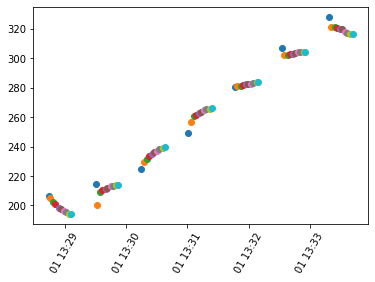

In [31]:
import datetime

for md in sea_img_metadata[:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

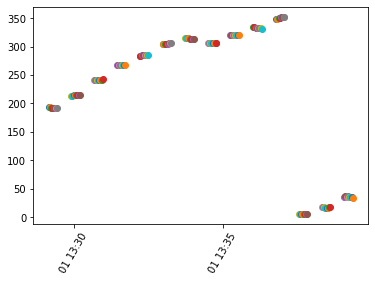

In [34]:
import datetime

for md in mds[24:136]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

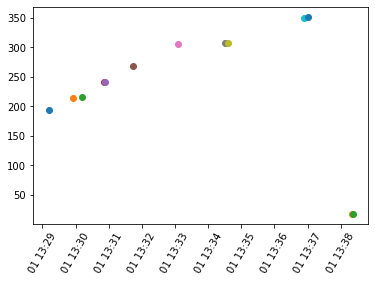

In [49]:
import datetime

for md in sky_img_metadata[2:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

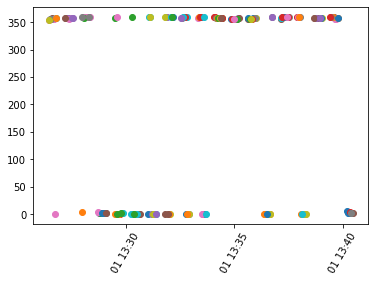

In [19]:
for md in mds:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['pitch'])
    plt.xticks(rotation=60)

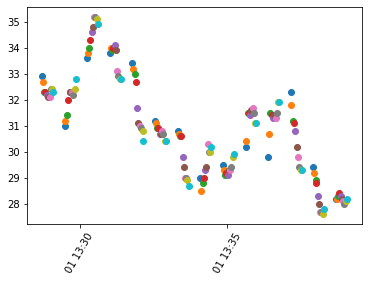

In [39]:
for md in mds[30:170]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['Altitude'])
    plt.xticks(rotation=60)

In [39]:
sea_imgs.nbytes / 1e9

9.9475488

In [40]:
sky_imgs.nbytes / 1e9

7.95803904

In [42]:
sea_img_metadata

[{'Latitude': 34.71521388888889,
  'Longitude': -76.67316666666667,
  'Altitude': 19.2,
  'UTC-Time': '13:26:26',
  'Date': '04/07/2021',
  'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/21JUiicmpKbtesGKh4IH.tif',
  'filename': '21JUiicmpKbtesGKh4IH.tif',
  'yaw': 262.642578156496,
  'pitch': 353.93212970596005,
  'roll': 7.002910573085387,
  'id': 0},
 {'Latitude': 34.715205555555556,
  'Longitude': -76.67331111111112,
  'Altitude': 22.4,
  'UTC-Time': '13:26:31',
  'Date': '04/07/2021',
  'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/RQhE0pS5CCMeizJqusiy.tif',
  'filename': 'RQhE0pS5CCMeizJqusiy.tif',
  'yaw': 264.38787546246033,
  'pitch': 355.1901069684007,
  'roll': 4.833103411427999,
  'id': 1},
 {'Latitude': 34.71520277777778,
  'Longitude': -76.67335555555556,
  'Altitude': 23.3,
  'UTC-Time': '13:26:33',
  'Date': '04/07/2021',
  'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/5ijPfM21i1ddYpOwle8M.tif',
  'filename': 

Inspect the bands either through time or sorted by pitch/yaw/lat/ etc

In [51]:
sea_img_md_pitch_sort = sorted(sea_img_metadata[1:], key=lambda k: k['pitch'])

sky_img_md_pitch_sort = sorted(sky_img_metadata[2:], key=lambda k: k['pitch'])

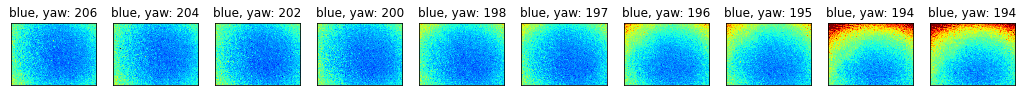

In [47]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue, yaw: ' + str(int(sea_img_metadata[i]['yaw'])))
    im = ax[i].imshow(sea_imgs[i][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])


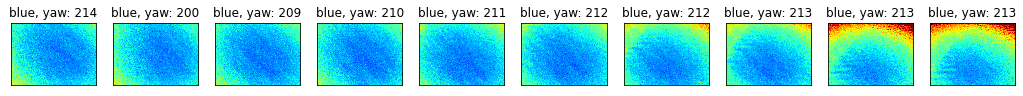

In [48]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue, yaw: ' + str(int(sea_img_metadata[i+10]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+10][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])


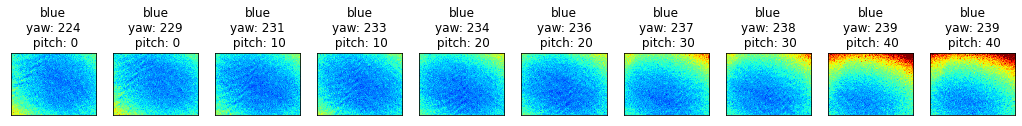

In [125]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+20]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+20][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

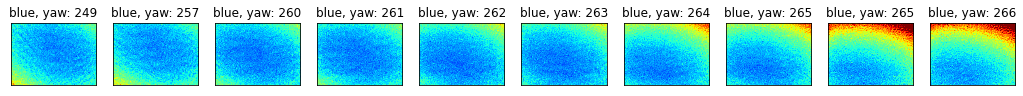

In [50]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue, yaw: ' + str(int(sea_img_metadata[i+30]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+30][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

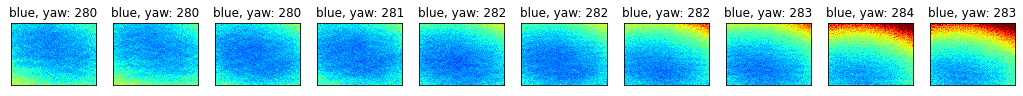

In [51]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue, yaw: ' + str(int(sea_img_metadata[i+40]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+40][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

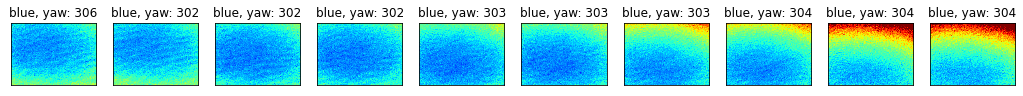

In [52]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue, yaw: ' + str(int(sea_img_metadata[i+50]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+50][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

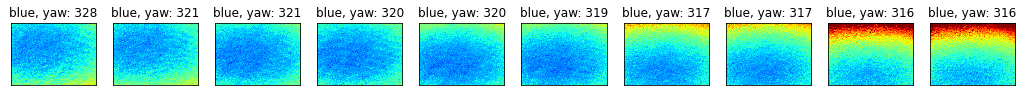

In [53]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue, yaw: ' + str(int(sea_img_metadata[i+60]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+60][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

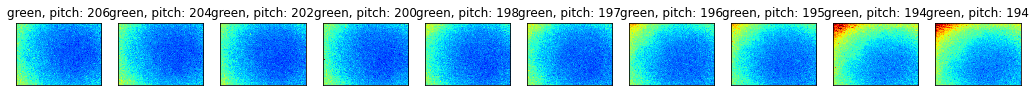

In [69]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green, yaw: ' + str(int(sea_img_metadata[i+0]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+0][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

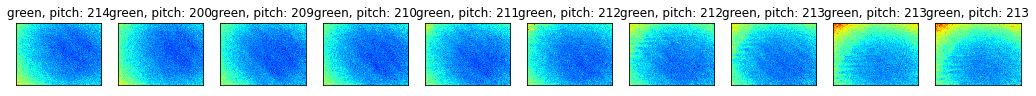

In [70]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green, yaw: ' + str(int(sea_img_metadata[i+10]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+10][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

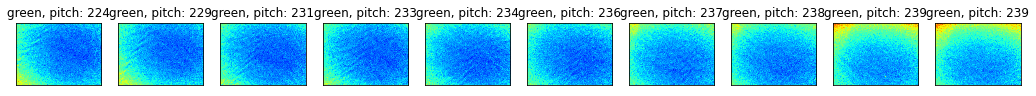

In [71]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green, yaw: ' + str(int(sea_img_metadata[i+20]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+20][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

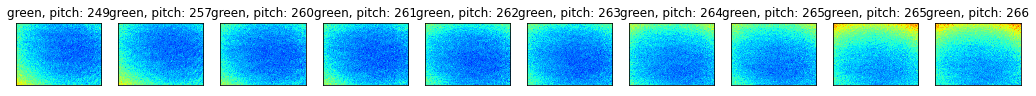

In [72]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green, yaw: ' + str(int(sea_img_metadata[i+30]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+30][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

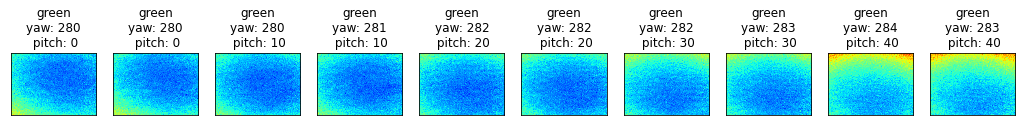

In [124]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+40]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+40][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

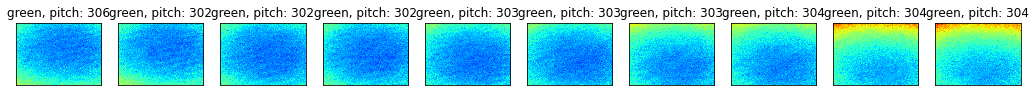

In [74]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green, yaw: ' + str(int(sea_img_metadata[i+50]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+50][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

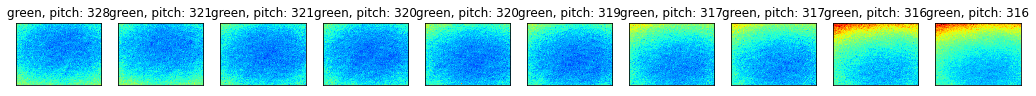

In [75]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green, yaw: ' + str(int(sea_img_metadata[i+60]['yaw'])))
    im = ax[i].imshow(sea_imgs[i+60][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [63]:
sky_img_md_pitch_sort= sorted(sky_img_metadata[:], key=lambda k: k['pitch']) 
len(sky_img_md_pitch_sort)

7

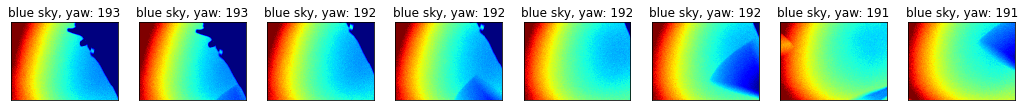

In [186]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i]['yaw'])))
    im = ax[i].imshow(sky_imgs[i][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

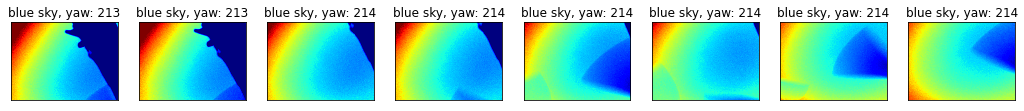

In [187]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8]['yaw'])))
    im = ax[i].imshow(sky_imgs[i+8][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

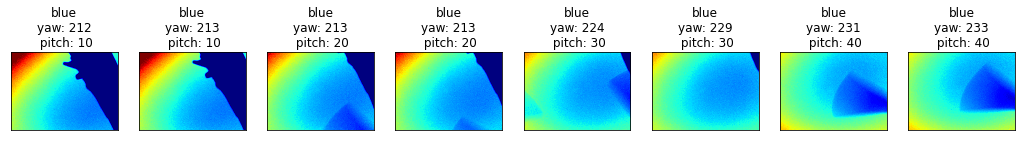

In [188]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    #ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*2]['yaw'])))
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*2]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*2][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

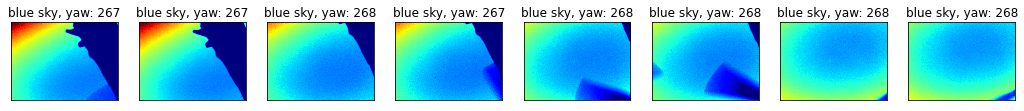

In [189]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*3]['yaw'])))
    im = ax[i].imshow(sky_imgs[i+8*3][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

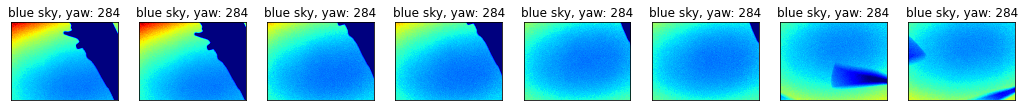

In [190]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*4]['yaw'])))
    im = ax[i].imshow(sky_imgs[i+8*4][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

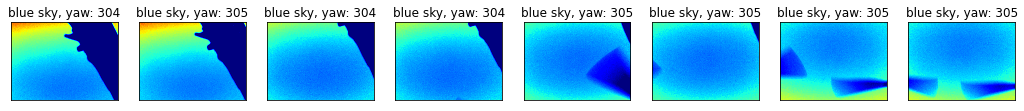

In [191]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*5]['yaw'])))
    im = ax[i].imshow(sky_imgs[i+8*5][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

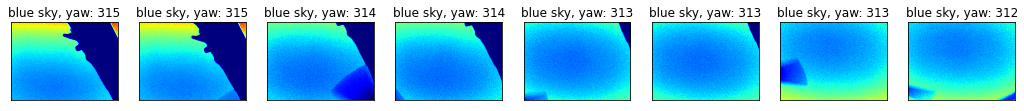

In [192]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*6]['yaw'])))
    im = ax[i].imshow(sky_imgs[i+8*6][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

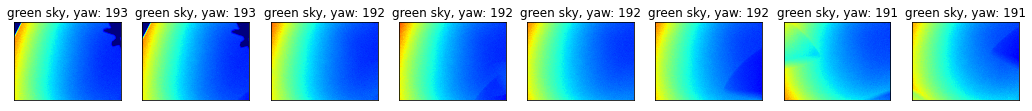

In [83]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('green sky, yaw: ' + str(int(sky_img_metadata[i]['yaw'])))
    im = ax[i].imshow(sky_imgs[i][1], interpolation='none', 
                   cmap='jet', vmin=0.05, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

#### inspect the sun blocked spectra based on the brightest pics there

In [94]:
blocked_imgs.shape

(7, 5, 945, 1268)

brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599


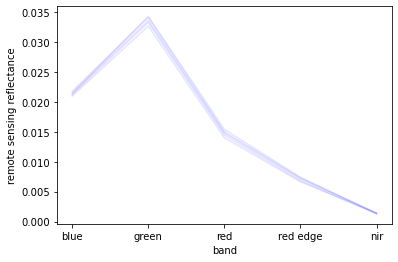

In [23]:
blocked_spectra = []
for i in range(0,5):
    spec = brightest_tube_pix(blocked_imgs[i], percent=0.0005)
    plt.plot(band_names, spec, color='blue', alpha=0.1)
    plt.ylabel('remote sensing reflectance')
    plt.xlabel('band')
    blocked_spectra.append(spec)
blocked_spectra = np.array(blocked_spectra)

brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119


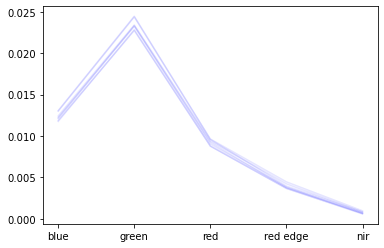

In [18]:
blocked_spectra = []
for i in range(0,7):
    spec = brightest_tube_pix(blocked_imgs[i])
    plt.plot(band_names, spec, color='blue', alpha=0.1)
    blocked_spectra.append(spec)
blocked_spectra = np.array(blocked_spectra)

#### inspect some bands after trimming the brightest picss

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


2368464
2368464
2368464
2368464
2368464


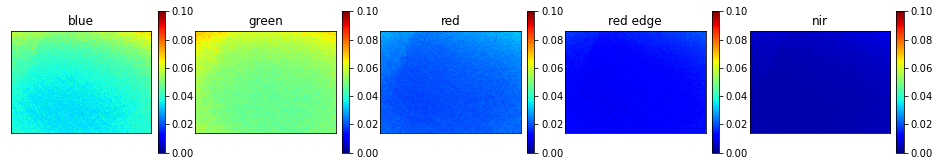

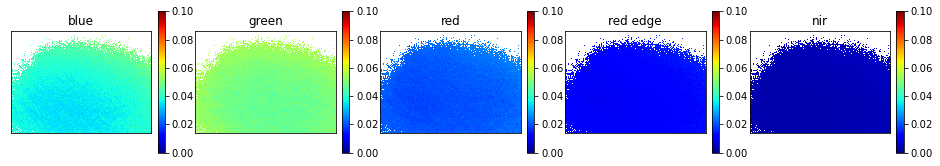

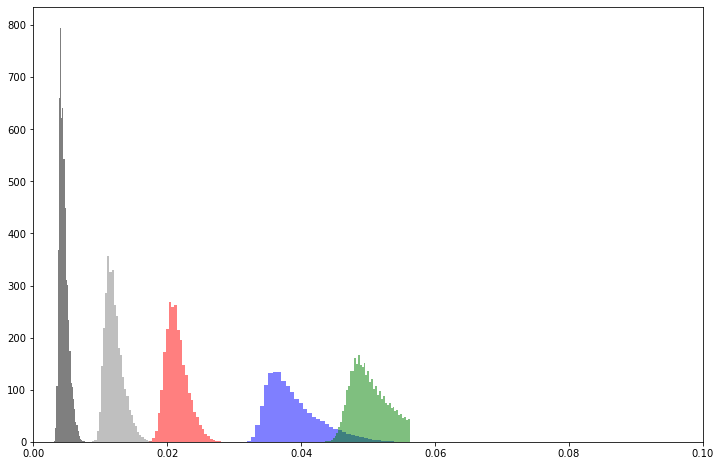

In [129]:
lowest_percent = 0.80
dark_pix_dark = visualize_darkest_pixels(sea_imgs[29], lowest_percent=lowest_percent, band=1)

### Visualize some of the rededge data for the correction

In [138]:
sky_re_imgs.shape, sea_re_imgs.shape

((4, 5, 946, 1267), (9, 5, 946, 1267))

pitch 55.22378489978678
231.59169870567823
pitch 59.981352264989084
249.39674060544104


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


pitch 59.28543112523056
248.81318506371252
pitch 59.609122592910694
248.2294867305343
pitch 59.68638973056699
246.60952223247872
pitch 61.014638603875596
242.58189136495963
pitch 55.40071388953356
240.43571902219384
pitch 55.12979555593489
239.19015596776558


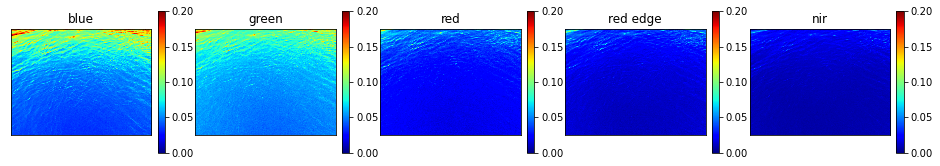

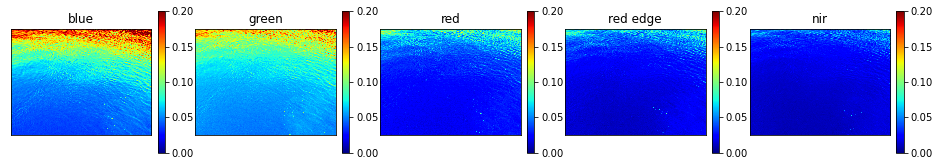

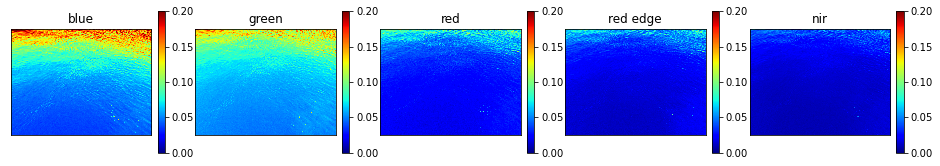

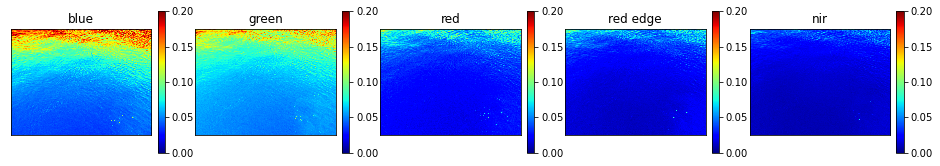

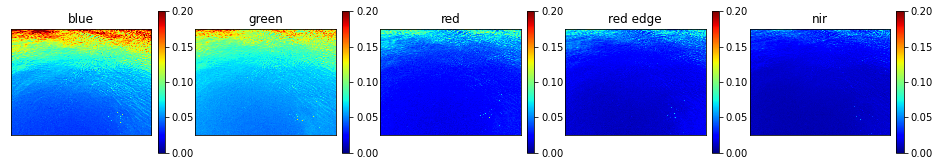

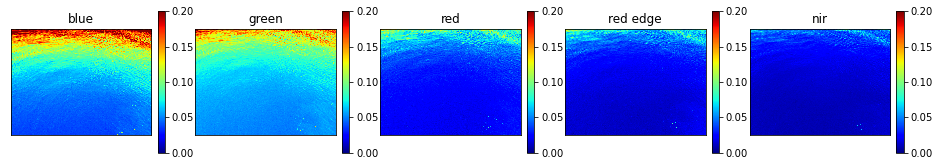

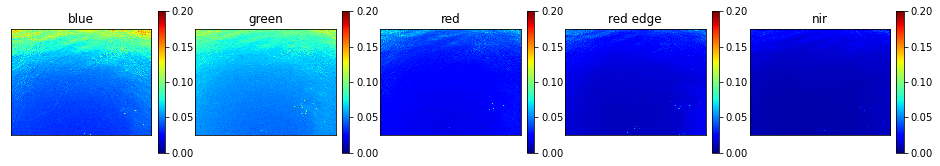

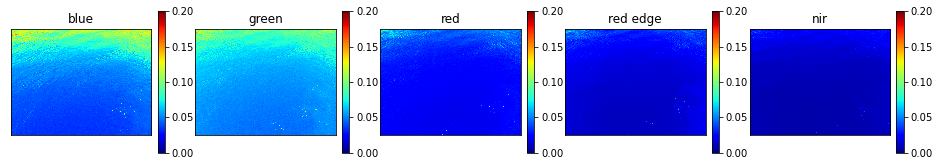

In [169]:
for i in range(0,8):
    print('pitch', sea_re_img_metadata[i]['pitch'])
    print(sea_re_img_metadata[i]['yaw'])
    visualize_darkest_pixels(sea_re_imgs[i], lowest_percent=1, max_clim=0.2, only_img=True)

pitch 37.24920074044252
57.145434939278175
pitch 39.40261551786597
54.71224316974633


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


pitch 45.63918681770838
53.38104661148208
pitch 42.59217228666313
56.883200578649564


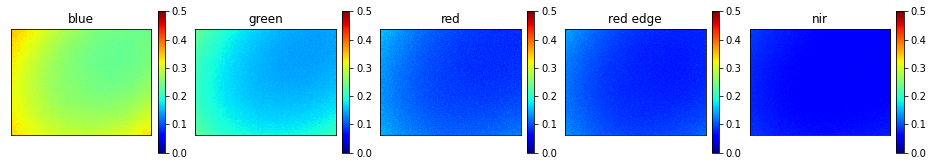

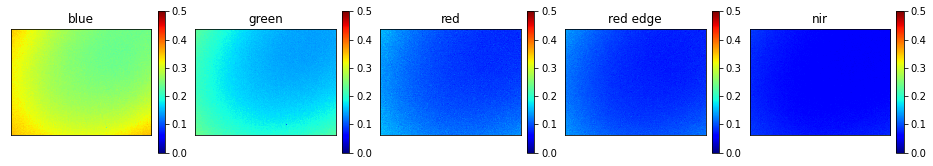

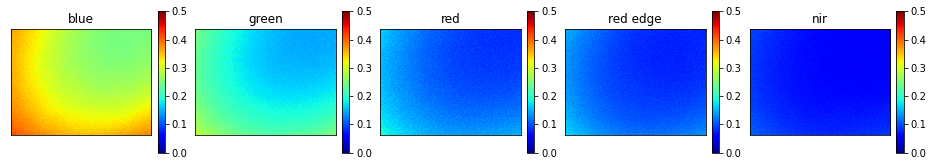

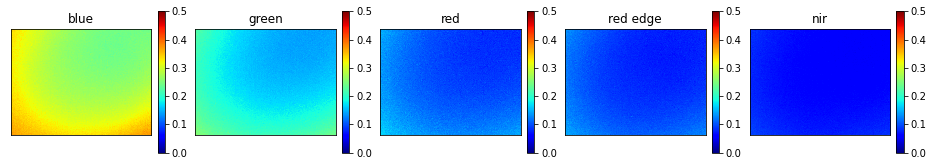

In [168]:
for i in range(0,4):
    print('pitch', sky_re_img_metadata[i]['pitch'])
    print(sky_re_img_metadata[i]['yaw'])
    visualize_darkest_pixels(sky_re_imgs[i], lowest_percent=1, max_clim=0.5, only_img=True)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


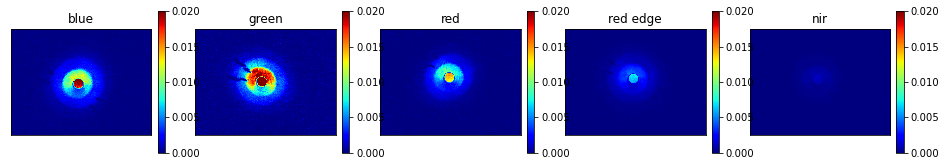

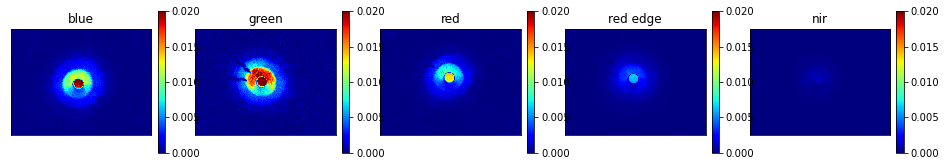

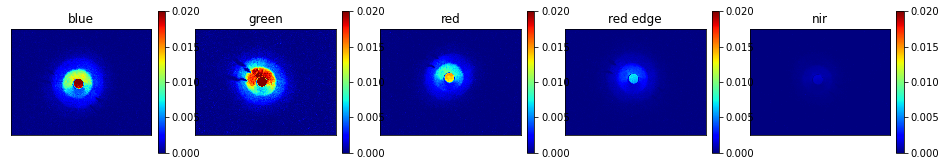

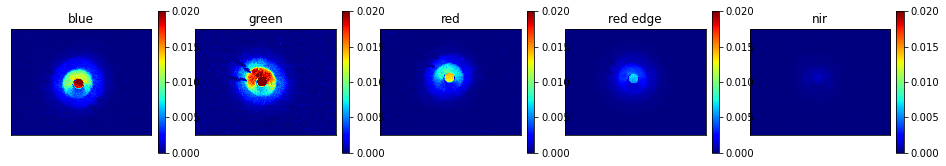

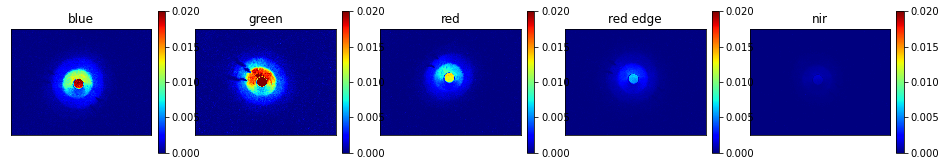

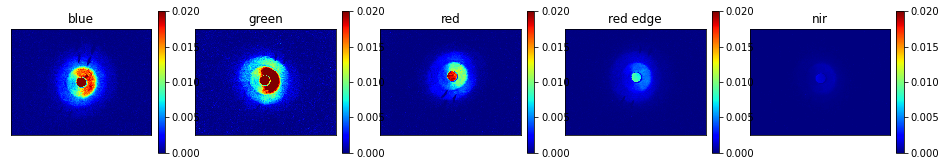

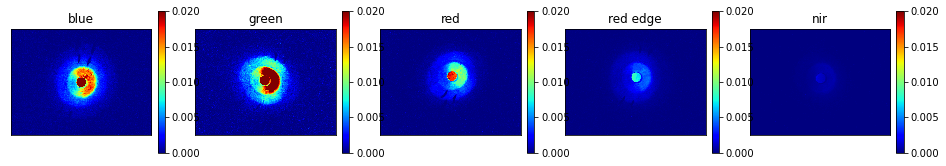

In [130]:
for i in range(0,7):
    visualize_darkest_pixels(blocked_imgs[i], lowest_percent=1, max_clim=0.02, only_img=True)

In [ ]:
for i in range(0,8):
    visualize_darkest_pixels(sea_imgs[i], lowest_percent=.8, only_img=False)

### Correct for sun glint

TODO currently just averaging sky spectra for removal but could easily interpolate across and incorporate time into which is chosen

This is the old approach based on ruddick and Mobley

In [131]:
def sun_glint_removal(sea_spectra, sky_spectra, wind_speed, method='ruddick2006'):
    sky_spectra = np.median(sky_spectra,axis=0)
    water_leaving_spectra = []
    # TODO will add in Zhang and other approaches
    print((0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed))
    if method == 'ruddick2006':
        for water_spec in sea_spectra:
            water_leaving = np.array(water_spec) - np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed)
            #water_leaving = water_leaving - water_leaving[4]
            # TODO if red edge is greater than ~.1 then it is cloudy and don't need wind correction just use 0.0256
            water_leaving_spectra.append(water_leaving)
    return(water_leaving_spectra)

### This is the current approach to calculating rho based on sunblocked spectra

In [24]:
import scipy.ndimage as ndimage

In [25]:
def calculate_rho(sea_imgs, sky_imgs, blocked_spec, visualize=True):
    # sea and sky img arrays are shape [img count, bands, rows, cols]
    # TODO calculate blurred sea and blurred sky for multiple images
    # TODO this could also be a surface fit to the image
    
    # note the smoothing process is quite slow and takes a while if you have too many images
    Lt_smooth_imgs = []
    for i in range(sea_imgs.shape[0]):
        Lt_smooth = ndimage.gaussian_filter(sea_imgs[i], sigma=(0, 60, 60), order=0)
        Lt_smooth_imgs.append(Lt_smooth)
    print(np.array(Lt_smooth_imgs).shape)
    Lt_smooth = np.mean(np.array(Lt_smooth_imgs), axis=0)
    # get lt minus lw
    Lt_Lw = (Lt_smooth.T - blocked_spec).T

    Lsky_smooth_imgs = []
    for i in range(sky_imgs.shape[0]):
        # flip lsky because the lowest part of the sea img is reflecting off the highest part of the sky
        Lsky = sky_imgs[i,:,::-1,:] # this flips the rows
        # smooth it out TODO could fit a surface to this too
        Lsky_smooth = ndimage.gaussian_filter(Lsky, sigma=(0, 20, 20), order=0)
        Lsky_smooth_imgs.append(Lsky_smooth)
        
    Lsky_smooth = np.mean(np.array(Lsky_smooth_imgs), axis=0)
    
    # divide this by the smoothed lsky
    rho = Lt_Lw / Lsky_smooth
    
    if visualize:
        fig, ax = plt.subplots(4,5, figsize=(18,16))
        for i in range(5):
            im = ax[0,i].imshow(Lt_smooth[i],cmap='jet', vmin=0.001, vmax=.07)
            fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)
            ax[0,i].set_xticks([])
            ax[0,i].set_yticks([])
            ax[0,i].set_title('original Lt (smooth)')

            im = ax[1,i].imshow(Lt_Lw[i],cmap='jet', vmin=0.0, vmax=.04)
            fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks([])
            ax[1,i].set_title('lt - lw (spec)')

            im = ax[2,i].imshow(Lsky_smooth[i],cmap='jet', vmin=0.05, vmax=.4)
            fig.colorbar(im, ax=ax[2,i], fraction=0.046, pad=0.04)
            ax[2,i].set_xticks([])
            ax[2,i].set_yticks([])
            ax[2,i].set_title('lsky smooth (flip)')

            im = ax[3,i].imshow(rho[i],cmap='jet', vmin=0.0, vmax=.25)
            fig.colorbar(im, ax=ax[3,i], fraction=0.046, pad=0.04)
            ax[3,i].set_xticks([])
            ax[3,i].set_yticks([])
            ax[3,i].set_title('rho')
            fig.show()
        
    return(rho)

In [40]:
sea_imgs.shape[2]

1470

In [51]:
from skimage.transform import resize

def apply_rho(sea_img, sky_img, rho, visualize=True):

    # flip lsky because the lowest part of the sea img is reflecting off the highest part of the sky
    lsky = sky_img[:,::-1,:] # this flips the rows
    # smooth it out TODO could fit a surface to this too
    lsky_smooth = ndimage.gaussian_filter(lsky, sigma=(0, 20, 20), order=0)
    
    # rho needs to be the same size and it isn't when from the RedEdge
    
    rho_resized = []
    for i in range(rho.shape[0]):
        rho_resized.append(resize(rho[i], (sea_img.shape[1], sea_img.shape[2]), anti_aliasing=True))
    rho_resized = np.array(rho_resized)
    
    lw_img = sea_img - rho_resized * lsky_smooth
    print(lw_img.shape)
    
    if visualize:
        fig, ax = plt.subplots(5,5, figsize=(18,16))
        for i in range(5):
            im = ax[0,i].imshow(sea_img[i],cmap='jet', vmin=0.001, vmax=.04)
            fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)
            ax[0,i].set_xticks([])
            ax[0,i].set_yticks([])
            ax[0,i].set_title('original Lt')


            im = ax[1,i].imshow(lsky_smooth[i],cmap='jet', vmin=0.05, vmax=.3)
            fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks([])
            ax[1,i].set_title('lsky smooth (flip)')

            im = ax[2,i].imshow(rho_resized[i],cmap='jet', vmin=0.0, vmax=.15)
            fig.colorbar(im, ax=ax[2,i], fraction=0.046, pad=0.04)
            ax[2,i].set_xticks([])
            ax[2,i].set_yticks([])
            ax[2,i].set_title('rho (resized)')
            
            im = ax[3,i].imshow(rho_resized[i] * lsky_smooth[i],cmap='jet', vmin=0.0, vmax=.05)
            fig.colorbar(im, ax=ax[3,i], fraction=0.046, pad=0.04)
            ax[3,i].set_xticks([])
            ax[3,i].set_yticks([])
            ax[3,i].set_title('rho_resized * lsky_smooth')

            im = ax[4,i].imshow(lw_img[i],cmap='jet', vmin=0.001, vmax=.03)
            fig.colorbar(im, ax=ax[4,i], fraction=0.046, pad=0.04)
            ax[4,i].set_xticks([])
            ax[4,i].set_yticks([])
            ax[4,i].set_title('full lw')
            fig.show()
    return(lw_img)

### Apply that approach

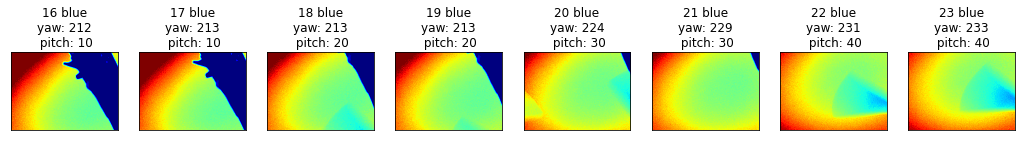

In [27]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    #ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*2]['yaw'])))
    ax[i].set_title(str(i+8*2) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+8*2]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*2][0], interpolation='none', 
                   cmap='jet', vmin=0.05, vmax=.4)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

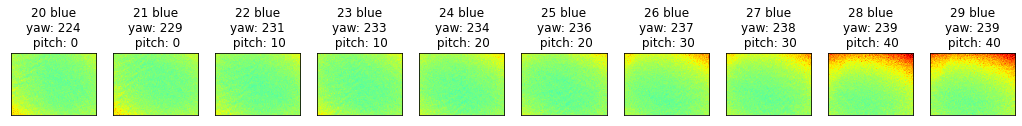

In [28]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title(str(i+20) +' blue\nyaw: ' + str(int(sea_img_metadata[i+20]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+20][0], interpolation='none', 
                   cmap='jet', vmin=0.0, vmax=.07)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

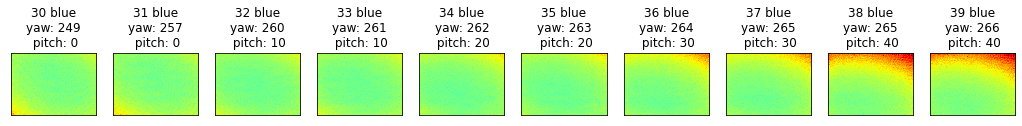

In [69]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title(str(i+30) +' blue\nyaw: ' + str(int(sea_img_metadata[i+30]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+30][0], interpolation='none', 
                   cmap='jet', vmin=0.0, vmax=.07)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [29]:
np.median(blocked_spectra,axis=0)

array([0.02136108, 0.0335728 , 0.01477112, 0.0070919 , 0.00137747])

In [57]:
sea_img_metadata[28]

{'Latitude': 34.71497222222222,
 'Longitude': -76.675275,
 'Altitude': 35.1,
 'UTC-Time': '13:30:36',
 'Date': '04/07/2021',
 'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/Q0W04uSHPBWJYzrr4s9l.tif',
 'filename': 'Q0W04uSHPBWJYzrr4s9l.tif',
 'yaw': 239.18234332680862,
 'pitch': 0.7618455954687988,
 'roll': 9.073311210410736,
 'id': 28}

In [58]:
sea_re_imgs.shape

(9, 5, 946, 1267)

In [68]:
np.median(sea_re_imgs[:,0])/np.median(sea_imgs[28,0])

1.3546375681995324

In [67]:
np.median(sea_re_imgs[2,0])/np.median(sea_imgs[21,0])

1.5637130801687764

(1, 5, 1470, 2014)


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


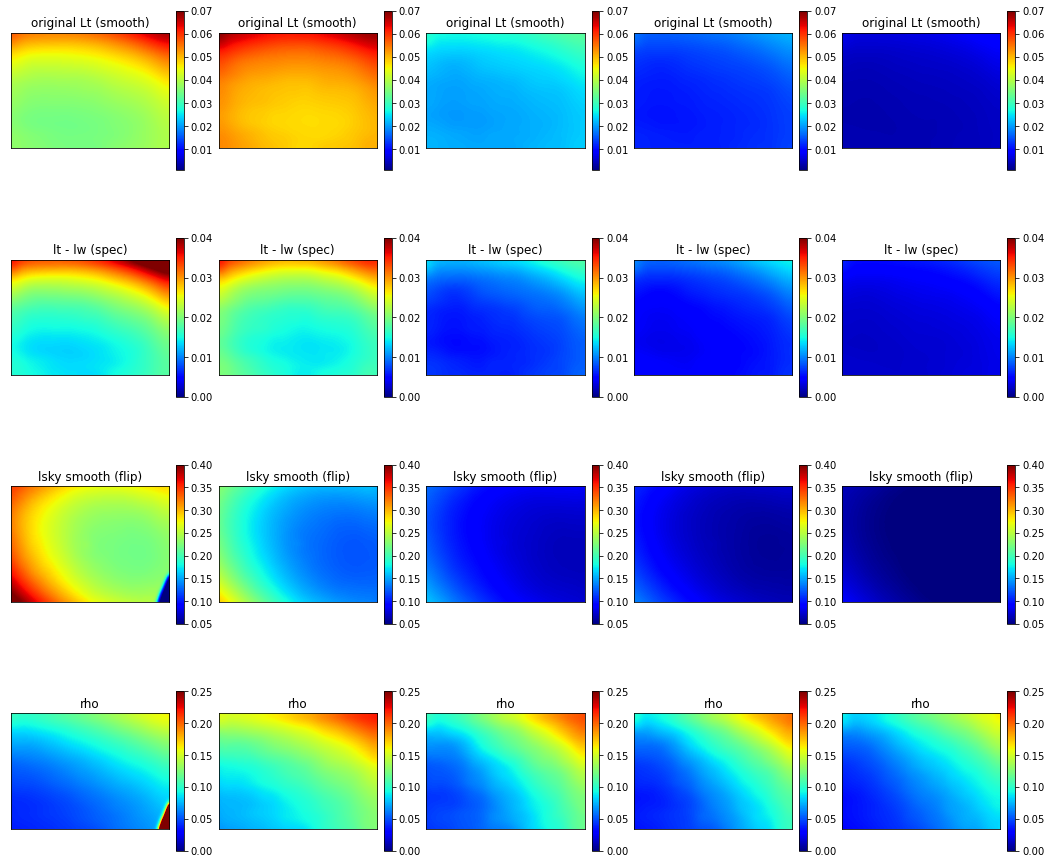

In [70]:
rho = calculate_rho(sea_imgs[38,:5][np.newaxis,...], 
              sky_imgs[21,:5][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

(9, 5, 946, 1267)


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


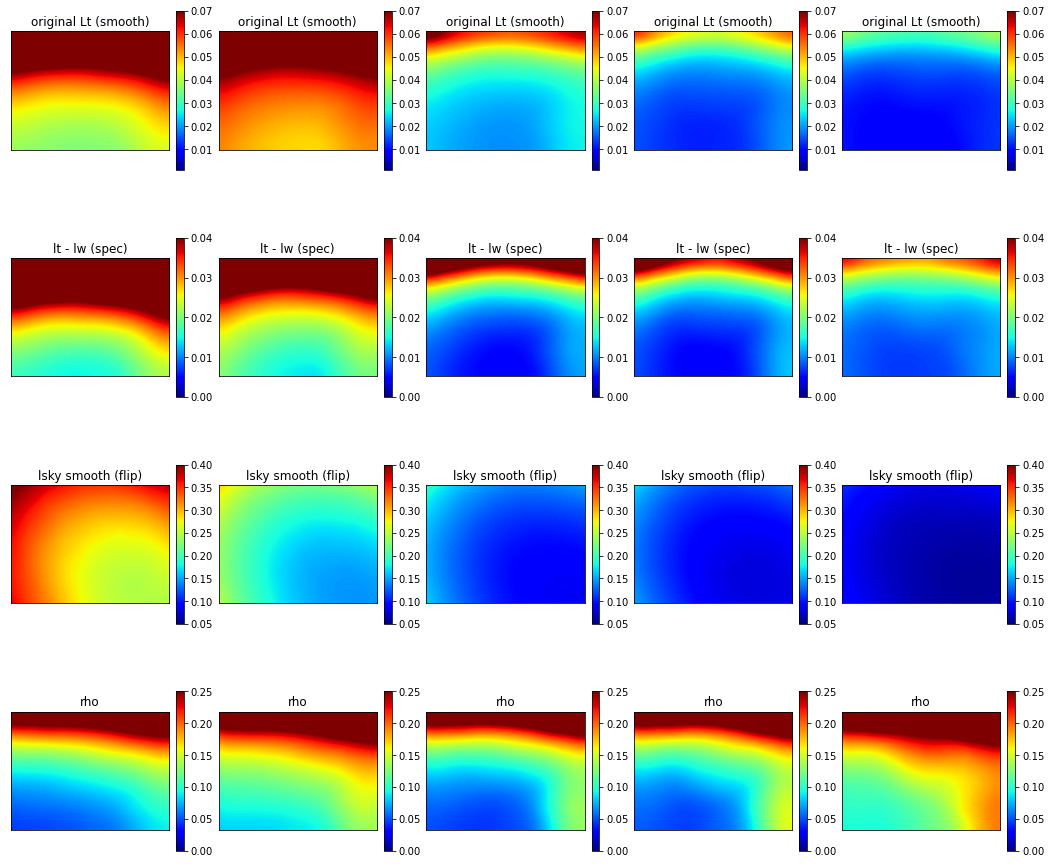

In [63]:
rho = calculate_rho(sea_re_imgs, 
              sky_re_imgs[2][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


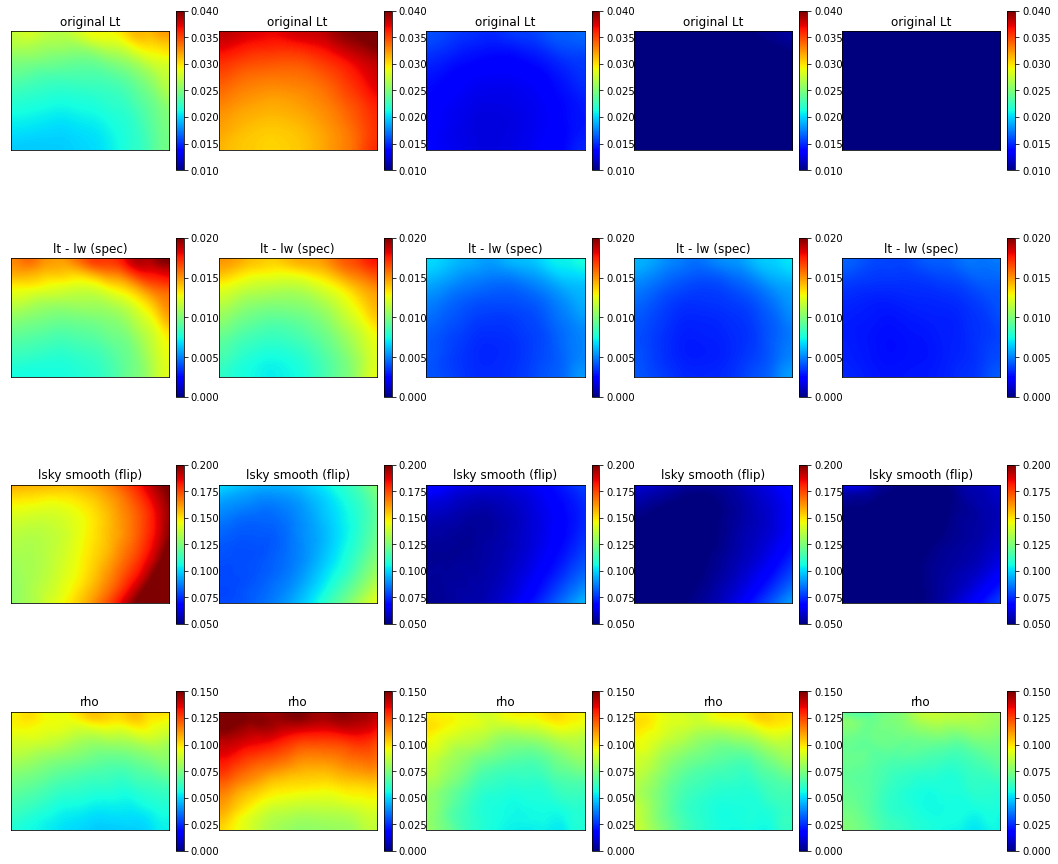

In [203]:
rho = calculate_rho(sea_imgs[sea_img_md_pitch_sort[7]['id']], 
              sky_imgs[sky_img_md_pitch_sort[3]['id']], 
              np.median(blocked_spectra,axis=0), visualize=True)

(5, 1470, 2014)


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


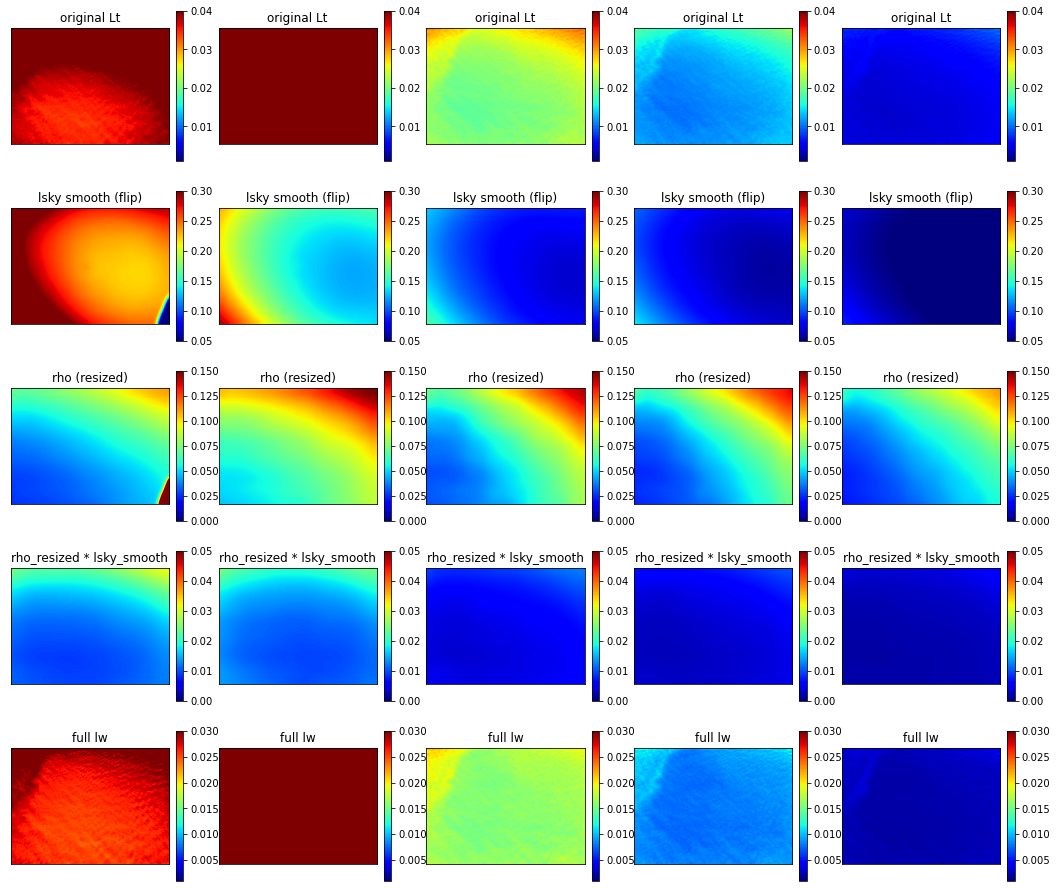

In [72]:
lw_processed = apply_rho(sea_imgs[28,:5], 
              sky_imgs[21,:5], rho/1.454, visualize=True)

#### Inspect the spectra from this

In [6]:
fig, ax = plt.subplots(figsize=(13,10))

for spectra in [np.median(sea_imgs[sea_img_md_pitch_sort[7]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='blue', alpha=0.5)
    
for spectra in [np.median(lw_processed,axis=(1,2))]:
    ax.plot(band_names, spectra, color='green', alpha=0.5)

for spectra in blocked_spectra:
    ax.plot(band_names, spectra, color='pink', alpha=0.5)
    
for spectra in [np.median(sky_imgs[sky_img_md_pitch_sort[3]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='lightblue', alpha=0.7)
    
#ax.plot(band_names, np.median(sky_spectra[0], axis=0), color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

NameError: name 'plt' is not defined

#### What does chla look like from these images

In [87]:
chla_lw = vec_chla_img(blue_lw, green_lw)

In [98]:
chla_lw[300:, 100:-100].shape

(647, 1067)

In [101]:
np.median(chla_lw)

6.3816071756413475

In [102]:
np.median(chla_lw[300:, 100:-100])

6.365109877580753

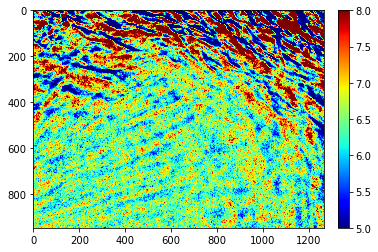

In [100]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw, cmap='jet', vmin=5,vmax=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

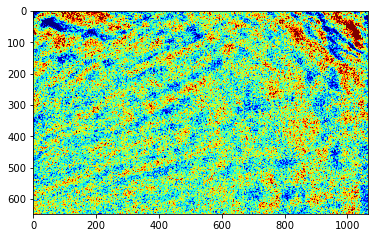

In [97]:
plt.imshow(chla_lw[300:, 100:-100], cmap='jet', vmin=5,vmax=8)

#### Now visualize a bunch of images and the chla from them

pitch: 0.7813185964237164
yaw: 304.93347128816885


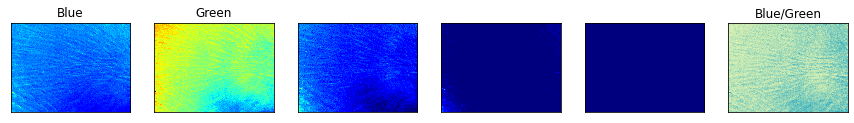

pitch: 2.8484284979807057
yaw: 302.53077525335925


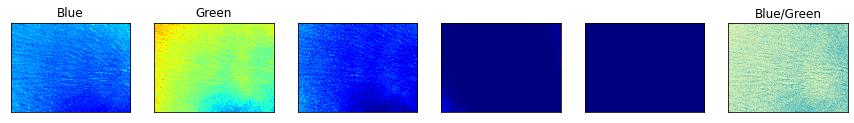

pitch: 3.6206177658294223
yaw: 301.4414487410652


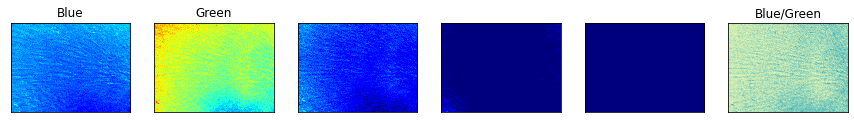

pitch: 4.721692730735867
yaw: 298.1653482965328


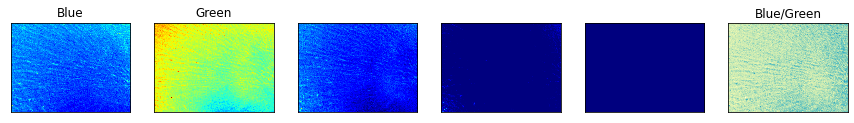

pitch: 5.120128671639236
yaw: 305.2211089662284


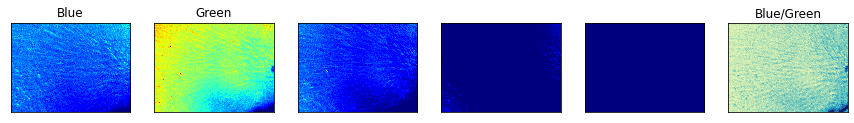

pitch: 8.867759744493128
yaw: 297.4514476679033


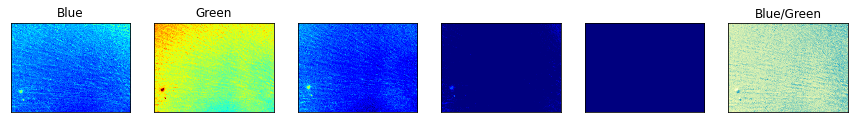

pitch: 14.537520990904625
yaw: 295.0259268435857


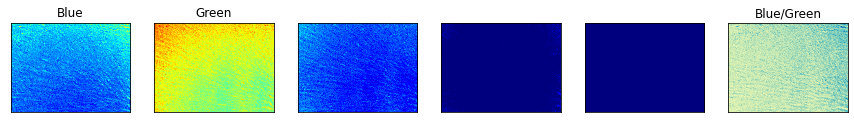

pitch: 14.72927694587986
yaw: 294.3668642045996


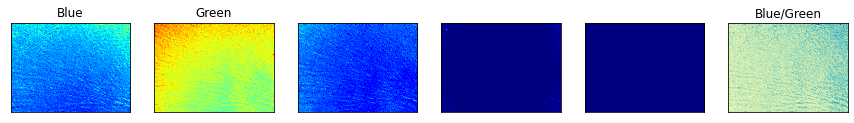

pitch: 18.58987542005042
yaw: 300.68554398471616


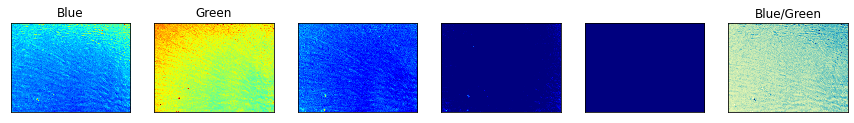

pitch: 21.552289944880386
yaw: 295.5408153471316


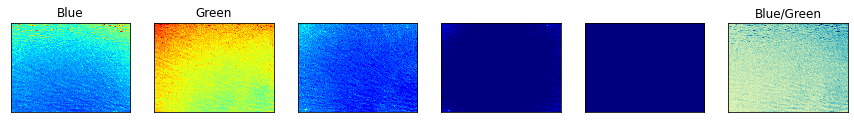

pitch: 28.688788660328328
yaw: 298.0796696209331


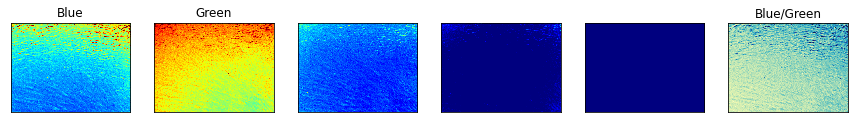

pitch: 30.059735205448305
yaw: 294.63023903277116


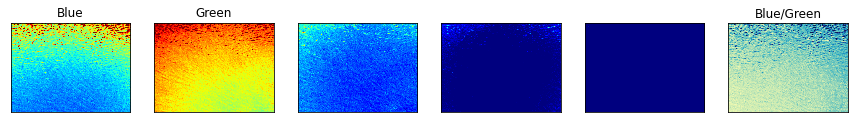

pitch: 31.532183905804573
yaw: 294.6144682255024


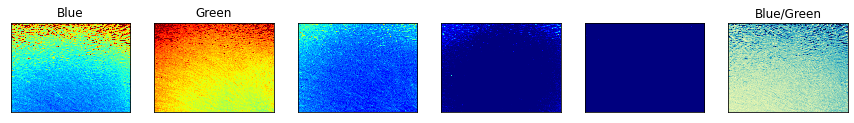

pitch: 35.50975389693423
yaw: 296.20690213826157


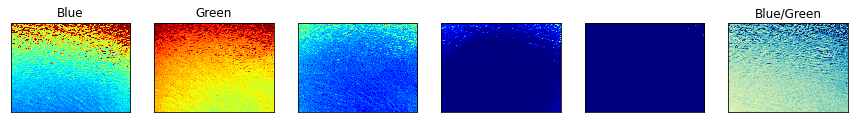

pitch: 38.21853591894268
yaw: 292.7428469723451


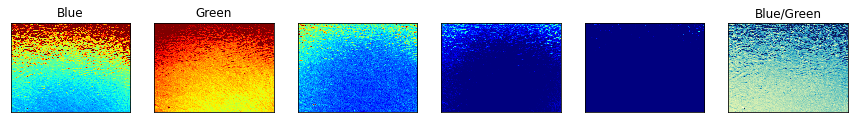

pitch: 42.79733112679867
yaw: 294.99385912732583


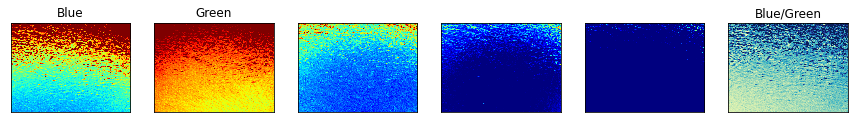

pitch: 46.578352076488784
yaw: 292.1382280748443


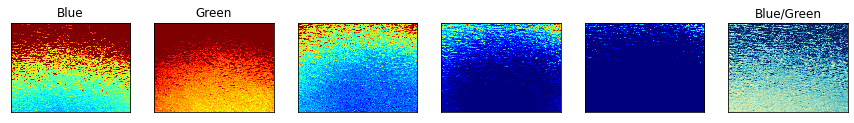

pitch: 50.35286895742746
yaw: 291.97495226550814


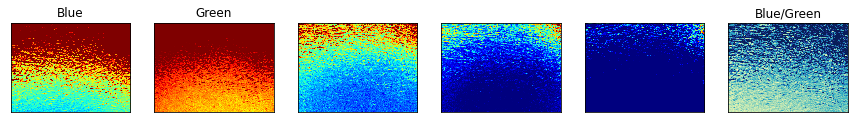

pitch: 58.804622029358086
yaw: 287.4272326639197


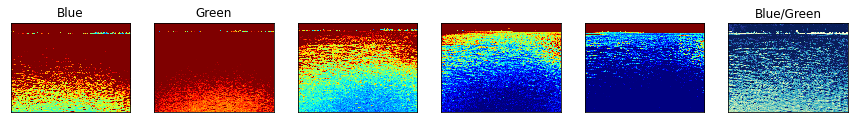

In [225]:
for i in range(0,19):
    fig, ax = plt.subplots(1,6, figsize=(15,3))
    print('pitch:',sea_img_md_pitch_sort[i]['pitch'])
    print('yaw:',sea_img_md_pitch_sort[i]['yaw'])
    ax[0].set_title("Blue")
    im = ax[0].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],0], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    #fig.colorbar(im,ax=ax[0])
    ax[1].set_title("Green")
    im2 = ax[1].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],1], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    #fig.colorbar(im2,ax=ax[1])
    im3 = ax[2].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],2], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    #fig.colorbar(im2,ax=ax[2])
    im4 = ax[3].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],3], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    #fig.colorbar(im2,ax=ax[3])
    im5 = ax[4].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],4], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[5].set_title("Blue/Green")
    im6 = ax[5].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],0]/sea_imgs[sea_img_md_pitch_sort[i]['id'],1], interpolation='none', 
                   cmap='YlGnBu', vmin=.5, vmax=1.2)
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    #fig.colorbar(im2,ax=ax[4])
    plt.show()

### Chlorophyll retrieval algorithm

Run chla retrieval on water leaving spectra

In [66]:
chla_list = []
for spectra in blocked_spectra:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[6.356087606017864,
 6.258882462214956,
 6.555905398674276,
 6.437045009156115,
 6.0705909634053805,
 6.0467082739748275,
 6.1363390346805025]

In [67]:
chla_list = []
for spectra in water_leaving_spec:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[3.725178152219733]

In [294]:
4.50674749003831 / 3.778

1.1928924007512731

In [68]:
for md in sea_img_metadata[:]:
    print(md['pitch'])

24.48100439092184
18.278774752899437
16.62868657249811
30.335922246084635
34.914430565022315
37.5013787624174
34.73575007534288
45.9768427574661
51.218735490343306
57.236565622612886
52.02441024442453
46.67323453974166
42.0941159243867
37.69342367764301
29.24397755315249
49.92532694279146


### Save spectra and chla values as a geopandas dataframe along with image metadata

In [69]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [70]:
from datetime import datetime
import pandas as pd

def convert_to_ocean_color_gdf(chla_list, spectra_list, img_metadata):
    chla_dates = []
    for im in img_metadata:
        date_time_str = im['Date'] + ' ' + im['UTC-Time']

        date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
        chla_dates.append(date_time_obj)
    lons = []
    lats = []
    alts = []
    for im in img_metadata:
        lons.append(im['Longitude'])
        lats.append(im['Latitude'])
        alts.append(im['Altitude'])
        
    chla_df = pd.DataFrame(
    {'chla': chla_list,
     'Latitude': lats,
     'Longitude': lons,
     'Altitude' : alts,
     'spectra' : spectra_list,
     'time' : chla_dates})

    chla_gdf = gpd.GeoDataFrame(
        chla_df, geometry=gpd.points_from_xy(chla_df.Longitude, chla_df.Latitude))
    
    return(chla_gdf)

In [ ]:
gdf = convert_to_ocean_color_gdf(chla_list, water_leaving_spec, [sea_img_metadata[i] for i in sea_idxs])
print(len(gdf))
gdf.head()

In [ ]:
import contextily as ctx
gdf.set_crs(epsg=4326, inplace=True)
web_merc_gdf = gdf.to_crs(epsg=3857)
fig,ax = plt.subplots(figsize=(12,12))
web_merc_gdf.plot(ax=ax, column='chla', vmax=6, vmin=3)
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot(ax=ax)
ctx.add_basemap(ax, zoom=12)
ax.set_ylim(4123102,4126102)
ax.set_xlim(-8537315, -8532315)

Save out the file

In [185]:
gdf.time = gdf.time.astype(str)
gdf.spectra = gdf.spectra.astype(str)
#gdf.to_file('data/260920_shearwateroffshore_dual/uas_data_260920_1_dark.shp')